In [13]:
pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

import re
import sys
import missingno as msno
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from PIL import Image
# from pandas_profiling import ProfileReport
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,precision_score,accuracy_score
from scipy.stats.mstats import winsorize

mod = sys.modules[__name__]
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [14]:
df_credit_2020 = pd.read_excel("2020_credit_rating.xlsx")
df_credit_2020.head()

,Unnamed: 0,평가회사,평가대상회사,평가대상종류,공시일자,평가등급,등급감시,등급전망
0,1,한국기업평가,삼성엔지니어링(주),본평가,2020-01-02,A-,NaN,안정적
1,2,한국기업평가,삼화페인트공업(주),수시평가,2020-01-02,BBB+,NaN,안정적
2,3,나이스신용평가,예금보험공사,본평가,2020-01-08,AAA,NaN,안정적
3,4,한국기업평가,에스케이증권(주),본평가,2020-01-09,A,NaN,안정적
4,5,한국기업평가,우리종합금융(주),본평가 (정정),2020-01-09,A,NaN,안정적


In [15]:
credit_dlist={"D":0,"C-":1,"C":2,"C+":3,"CC-":4,"CC":5,"CC+":6,"CCC-":7,"CCC":8,"CCC+":9,
              "B-":10,"B":11,"B+":12,"BB-":13,"BB":14,"BB+":15,"BBB-":16,"BBB":17,"BBB+":18,
              "A-":19,"A":20,"A+":21,"AA-":22,"AA":23,"AA+":24,"AAA-":25,"AAA":26,"AAA+":27}


def screen_name(df):
    df = df.rename(columns = {"평가대상회사":"기업명"})
    df = df[["기업명","공시일자","평가등급"]]
    df["공시일자"] = df["공시일자"].apply(lambda x: int(str(x)[:4]))
    df["평가등급"][df["평가등급"] == "취소"] = np.nan
    df["기업명"] = df["기업명"].apply(lambda x: str(x).replace("(주)",""))
    df = df.dropna()
    df = df.drop_duplicates(['기업명'],keep="last").reset_index(drop=True)
    df['평가등급'] = df['평가등급'].apply(credit_dlist.get)
    return df

In [16]:
credit_ls_2017_2020= ["2017_credit_rating.xlsx","2018_credit_rating.xlsx",
            "2019_credit_rating.xlsx","2020_credit_rating.xlsx"]
    
for a in credit_ls_2017_2020:
    regex = re.compile(r'\d\d\d\d')
    b = regex.search(a).group() 
    setattr(mod, 'df_credit_{}'.format(b), screen_name(pd.read_excel(a)))


/Users/yeonghwanchoi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
df_2013_2016_credit = pd.read_excel("2013-2016_credit_rating.xlsx")
df_2013_2016_credit.columns = ["nnamed", "평가회사","기업명","평가","평가대상종류","공시일자","평가등급","등급감시","등급전망"]
df_2013_2016_credit["공시일자"] = df_2013_2016_credit["공시일자"].apply(lambda x: int(str(x)[:4]))

In [18]:
for i in range(2013,2017):
    setattr(mod, 'df_credit_{}'.format(i),screen_name(df_2013_2016_credit[df_2013_2016_credit["공시일자"] == i]))

/Users/yeonghwanchoi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [19]:
def give_point(df1, df2): 
    df_n = pd.merge(df1, df2, on = "기업명", how = "inner").dropna()
    df_n["Point"] = df_n["평가등급_x"] - df_n["평가등급_y"]
    df_n["Point"][df_n["Point"].values != 0] =1
    df_n = pd.merge(df_n, df_credit_2014, on = "기업명", how="inner")
    return df_n[["기업명","Point"]]

In [20]:
df_2014 = give_point(df_credit_2013,df_credit_2014)
df_2015 = give_point(df_credit_2014,df_credit_2015)
df_2016 = give_point(df_credit_2015,df_credit_2016)
df_2017 = give_point(df_credit_2016,df_credit_2017)
df_2018 = give_point(df_credit_2017,df_credit_2018)
df_2019 = give_point(df_credit_2018,df_credit_2019)
df_2020 = give_point(df_credit_2019,df_credit_2020)

/Users/yeonghwanchoi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
df_credit_2014 = df_2014
df_credit_2015 = df_2015
df_credit_2016 = df_2016
df_credit_2017 = df_2017
df_credit_2018 = df_2018
df_credit_2019 = df_2019
df_credit_2020 = df_2020

In [22]:
df_esg = pd.read_csv("2011-2019-ESG.tsv", sep='\t')
df_esg.head()

,NO,기업명,기업코드,ESG등급,지배구조,사회,환경,평가년도,비고
0,6567,AJ네트웍스,95570,B,B,B,C이하,2019,NaN
1,6566,AJ렌터카,68400,C이하,C,B,B,2019,NaN
2,6565,AK홀딩스,6840,B,B,B,C이하,2019,NaN
3,6564,AP시스템,265520,C이하,B,C이하,C이하,2019,NaN
4,6563,BGF,27410,B,B,A,C이하,2019,NaN


In [23]:
df_esg = df_esg.drop(['NO', '비고'], axis=1).dropna()
df_esg["기업코드"] = df_esg["기업코드"].astype(str)
df_esg.기업코드 = df_esg.기업코드.apply(lambda x: x.zfill(6))

df_esg = df_esg.drop(['NO', '비고'], axis=1).dropna()
df_esg['ESG등급'] = df_esg['ESG등급'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg['지배구조'] = df_esg['지배구조'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg['사회']    = df_esg['사회'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg['환경']    = df_esg['환경'].apply({"S":70.0,"A+":60.0,"A":50.0,"B+":40.0,"B":30.0,"B이하":30.0,"C":20.0,"C이하":20.0,"D":10.0}.get) 
df_esg["기업코드"] = df_esg["기업코드"].apply(lambda x: str(x))
dflist = list(df_esg["기업코드"].values)
for i in range(len(df_esg)):
    if len(dflist[i]) < 3:
        dflist[i] = "0000" + dflist[i]
    elif len(dflist[i]) < 4:
        dflist[i] ="000" + dflist[i]
    elif len(dflist[i]) < 5:
        dflist[i] ="00" + dflist[i]
    elif len(dflist[i]) < 6:
        dflist[i] = "0" + dflist[i]
df_esg["기업코드"] = dflist 

In [19]:
mod = sys.modules[__name__]

for i in range(2011,2020):
    setattr(mod, 'df_esg_{}'.format(i),df_esg[df_esg["평가년도"]==i])
    

In [24]:
df3 = pd.read_excel("영업활동현금흐름.xlsx")
df3.tail()

FileNotFoundError: [Errno 2] No such file or directory: '영업활동현금흐름.xlsx'

In [22]:
df_f = ["영업활동현금흐름.xlsx","EBITDA.xlsx","CAPEX.xlsx","당기순이익.xlsx","자산총계.xlsx","매출액.xlsx","EBIT.xlsx",
       "부채비율.xlsx","차입부채_EBITDA.xlsx","EBITDA_이자비용.xlsx","총차입부채.xlsx"]

def change_columns(df):
    columns = ["종목코드","기업명","결산월","단위","2019","2018","2017","2016","2015","2014","2013","2012","2011","2010","2009","2008"]
    df.columns = columns
    df = df.rename(columns = {"종목코드":"기업코드"})
    return df

for i in range(1,12):
    setattr(mod, 'df_balance_{}'.format(i), change_columns(pd.read_excel(df_f[i-1])[9:]))
    

In [23]:
df_balance_3[df_balance_3.values == "N/A(IFRS)"] = np.nan
df_balance_10[df_balance_10.values == "완전잠식"] = np.nan
for i in range(4,16):
    df_balance_10.iloc[:,i] = df_balance_10.iloc[:,i].apply(lambda x: float(x))
    df_balance_8.iloc[:,i] = df_balance_10.iloc[:,i].apply(lambda x: float(x))

In [24]:
def merge_code(dfa,dfb):
    dfb = dfb[["기업코드","기업명"]][dfb["기업명"].isin(dfa["기업명"])]
    dfa = pd.merge(dfa,dfb, on="기업명",how="inner")
    return dfa

In [25]:
df_credit_2020.tail()

,기업명,Point,공시일자,평가등급
191,유안타증권,0,2020,21
192,동국제강,0,2020,16
193,한국해외인프라도시개발지원공사,0,2020,26
194,중국은행서울지점,0,2020,26
195,동국산업,0,2020,18


In [26]:
list_credit = [df_credit_2013,df_credit_2014,df_credit_2015,df_credit_2016,df_credit_2017,
             df_credit_2018,df_credit_2019]

list_esg = [df_esg_2011,df_esg_2012,df_esg_2013,df_esg_2014,df_esg_2015,df_esg_2016,
            df_esg_2017,df_esg_2018,df_esg_2019]

list_balance = [df_balance_1,df_balance_2,df_balance_3,df_balance_4,df_balance_5,
               df_balance_6,df_balance_7,df_balance_8,df_balance_9,df_balance_10,df_balance_11]

In [27]:
for i in range(2013,2020):
    setattr(mod, 'df_rating_{}'.format(i), merge_code(list_credit[i-2013],list_esg[i-2013]))

for k in range(2011, 2020):
    for i in range(1,12):
        setattr(mod, 'df_{}_{}'.format(k,i), pd.DataFrame(list_balance[i-1].iloc[:,[0,2023-k]]))

In [28]:
df_columns = ["기업코드","영업활동현금흐름","EBITDA","CAPEX","당기순이익","자산총계","매출액","EBIT","부채비율","차입부채_EBITDA","총차입부채","EBITDA_이자비용"]

In [29]:
data_frames_2011 = [df_2011_1,df_2011_2,df_2011_3,df_2011_4,df_2011_5,df_2011_6,df_2011_7,df_2011_8,df_2011_9,df_2011_10,df_2011_11,]
df_merged_2011 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2011).dropna()
df_merged_2011.columns = df_columns

data_frames_2012 = [df_2012_1,df_2012_2,df_2012_3,df_2012_4,df_2012_5,df_2012_6,df_2012_7,df_2012_8,df_2012_9,df_2012_10,df_2012_11,]
df_merged_2012 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2012).dropna()
df_merged_2012.columns = df_columns

data_frames_2013 = [df_2013_1,df_2013_2,df_2013_3,df_2013_4,df_2013_5,df_2013_6,df_2013_7,df_2013_8,df_2013_9,df_2013_10,df_2013_11,]
df_merged_2013 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2013).dropna()
df_merged_2013.columns = df_columns

data_frames_2014 = [df_2014_1,df_2014_2,df_2014_3,df_2014_4,df_2014_5,df_2014_6,df_2014_7,df_2014_8,df_2014_9,df_2014_10,df_2014_11,]
df_merged_2014 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2014).dropna()
df_merged_2014.columns = df_columns

data_frames_2015 = [df_2015_1,df_2015_2,df_2015_3,df_2015_4,df_2015_5,df_2015_6,df_2015_7,df_2015_8,df_2015_9,df_2015_10,df_2015_11,]
df_merged_2015 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2015).dropna()
df_merged_2015.columns = df_columns

data_frames_2016 = [df_2016_1,df_2016_2,df_2016_3,df_2016_4,df_2016_5,df_2016_6,df_2016_7,df_2016_8,df_2016_9,df_2016_10,df_2016_11,]
df_merged_2016 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2016).dropna()
df_merged_2016.columns = df_columns

data_frames_2017 = [df_2017_1,df_2017_2,df_2017_3,df_2017_4,df_2017_5,df_2017_6,df_2017_7,df_2017_8,df_2017_9,df_2017_10,df_2017_11,]
df_merged_2017 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2017).dropna()
df_merged_2017.columns = df_columns

data_frames_2018 = [df_2018_1,df_2018_2,df_2018_3,df_2018_4,df_2018_5,df_2018_6,df_2018_7,df_2018_8,df_2018_9,df_2018_10,df_2018_11,]
df_merged_2018 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2018).dropna()
df_merged_2018.columns = df_columns

data_frames_2019 = [df_2019_1,df_2019_2,df_2019_3,df_2019_4,df_2019_5,df_2019_6,df_2019_7,df_2019_8,df_2019_9,df_2019_10,df_2019_11,]
df_merged_2019 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_2019).dropna()
df_merged_2019.columns = df_columns

In [30]:
df_merged_2019.describe()

,영업활동현금흐름,EBITDA,CAPEX,당기순이익,자산총계,매출액,EBIT,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용
count,1.288000e+03,1.288000e+03,1.288000e+03,1.288000e+03,1.288000e+03,1.288000e+03,1.288000e+03,1.288000e+03,1288.000000,1.288000e+03,1.288000e+03
mean,1.334347e+08,1.870853e+08,1.569555e+08,4.194805e+07,2.268190e+09,1.557365e+09,8.147767e+07,6.273801e+03,7.347329,6.252352e+03,6.096380e+08
std,1.367813e+09,1.744299e+09,1.436090e+09,6.388664e+08,1.492753e+10,9.002992e+09,8.192695e+08,2.027864e+05,37.013212,2.027868e+05,3.828908e+09
min,-2.947197e+09,3.858400e+04,-8.999175e+08,-2.872078e+09,4.314290e+06,2.967891e+06,-1.359382e+09,2.000000e-02,0.000000,2.000000e-02,0.000000e+00
25%,2.644731e+06,5.456866e+06,1.944504e+06,5.030735e+05,9.875355e+07,6.990641e+07,1.911250e+06,3.870000e+00,0.727500,4.147500e+00,8.275888e+06
50%,1.145692e+07,1.591900e+07,8.389338e+06,5.061834e+06,2.251295e+08,1.816050e+08,8.212478e+06,1.169500e+01,2.730000,1.142000e+01,3.536976e+07
75%,4.068350e+07,5.297857e+07,3.430574e+07,1.908353e+07,6.726873e+08,5.758657e+08,2.969905e+07,6.354500e+01,5.885000,6.010750e+01,1.404174e+08
max,4.538292e+10,5.736615e+10,3.981829e+10,2.173886e+10,3.525645e+11,2.304009e+11,2.776851e+10,7.267918e+06,998.860000,7.267918e+06,8.214014e+10


In [31]:
df_merged_2011["FCF"] = df_merged_2011["영업활동현금흐름"] - df_merged_2011["CAPEX"]
df_merged_2011["EBIT_매출액"] = df_merged_2011["EBIT"]/df_merged_2011["매출액"]

df_merged_2012["FCF"] = df_merged_2012["영업활동현금흐름"] - df_merged_2012["CAPEX"]
df_merged_2012["EBIT_매출액"] = df_merged_2012["EBIT"]/df_merged_2012["매출액"]

df_merged_2013["FCF"] = df_merged_2013["영업활동현금흐름"] - df_merged_2013["CAPEX"]
df_merged_2013["EBIT_매출액"] = df_merged_2013["EBIT"]/df_merged_2013["매출액"]

df_merged_2014["FCF"] = df_merged_2014["영업활동현금흐름"] - df_merged_2014["CAPEX"]
df_merged_2014["EBIT_매출액"] = df_merged_2011["EBIT"]/df_merged_2011["매출액"]

df_merged_2015["FCF"] = df_merged_2015["영업활동현금흐름"] - df_merged_2015["CAPEX"]
df_merged_2015["EBIT_매출액"] = df_merged_2015["EBIT"]/df_merged_2015["매출액"]

df_merged_2016["FCF"] = df_merged_2016["영업활동현금흐름"] - df_merged_2016["CAPEX"]
df_merged_2016["EBIT_매출액"] = df_merged_2016["EBIT"]/df_merged_2016["매출액"]

df_merged_2017["FCF"] = df_merged_2017["영업활동현금흐름"] - df_merged_2017["CAPEX"]
df_merged_2017["EBIT_매출액"] = df_merged_2017["EBIT"]/df_merged_2017["매출액"]

df_merged_2018["FCF"] = df_merged_2018["영업활동현금흐름"] - df_merged_2018["CAPEX"]
df_merged_2018["EBIT_매출액"] = df_merged_2018["EBIT"]/df_merged_2018["매출액"]

df_merged_2019["FCF"] = df_merged_2019["영업활동현금흐름"] - df_merged_2019["CAPEX"]
df_merged_2019["EBIT_매출액"] = df_merged_2019["EBIT"]/df_merged_2019["매출액"]

In [32]:
data_frames_a_2011 = [df_merged_2011,df_esg_2011]
df_merged_b_2011 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2011).dropna()

data_frames_a_2012 = [df_merged_2012,df_esg_2012]
df_merged_b_2012 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2012).dropna()

data_frames_a_2013 = [df_merged_2013,df_esg_2013]
df_merged_b_2013 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2013).dropna()

data_frames_a_2014 = [df_merged_2014,df_esg_2014]
df_merged_b_2014 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2014).dropna()

data_frames_a_2015 = [df_merged_2015,df_esg_2015]
df_merged_b_2015 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2015).dropna()

data_frames_a_2016 = [df_merged_2016,df_esg_2016]
df_merged_b_2016 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2016).dropna()

data_frames_a_2017 = [df_merged_2017,df_esg_2017]
df_merged_b_2017 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2017).dropna()

data_frames_a_2018 = [df_merged_2018,df_esg_2018]
df_merged_b_2018 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2018).dropna()

data_frames_a_2019 = [df_merged_2019,df_esg_2019]
df_merged_b_2019 = reduce(lambda left,right: pd.merge(left,right,on=['기업코드'], how='inner'), data_frames_a_2019).dropna()

In [33]:
df_merged_b_2011 = df_merged_b_2011.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2012 = df_merged_b_2012.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2013 = df_merged_b_2013.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2014 = df_merged_b_2014.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2015 = df_merged_b_2015.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2016 = df_merged_b_2016.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2017 = df_merged_b_2017.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2018 = df_merged_b_2018.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]
df_merged_b_2019 = df_merged_b_2019.iloc[:,[0,2,4,5,6,8,9,10,11,12,13,15,16,17,18]]

In [34]:
columns = ['기업코드', 'EBITDA','EBITDA_이자비용','EBIT_매출액','총차입부채','당기순이익', '자산총계', '매출액','부채비율', 'FCF', 'ESG등급', '지배구조', '사회', '환경']

In [35]:
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)
df_merged_z_2012 = df_merged_b_2012[df_merged_b_2012["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2012["기업코드"])))].reset_index(drop=True)

In [36]:
df_merged_z_2012.head()

,기업코드,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,FCF,EBIT_매출액,ESG등급,지배구조,사회,환경
0,000020,22203932.0,1311241.0,3.242847e+08,2.233720e+08,21.03,0.45,21.03,1.000000e+07,1.84658e+07,0.044781,30.0,40.0,30.0,30.0
1,000050,30340204.0,-7910168.0,1.335040e+09,3.336208e+08,1.64,13.69,1.64,4.153193e+08,-2.01876e+07,0.021743,30.0,30.0,30.0,30.0
2,000070,62369435.0,129744740.0,2.748399e+09,1.864066e+09,2.58,10.36,2.58,6.462661e+08,-3.50113e+08,0.010664,30.0,30.0,30.0,40.0
3,000080,288819050.0,103536195.0,3.518666e+09,2.034626e+09,3.57,4.71,3.57,1.360940e+09,-1.98649e+08,0.082155,40.0,40.0,30.0,40.0
4,000120,229897603.0,69571921.0,3.669501e+09,2.627466e+09,11.80,3.74,11.80,8.589212e+08,-1.39541e+08,0.054436,30.0,30.0,40.0,30.0


In [37]:
df_merged_c_2014 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2014["기업코드"] = df_merged_z_2014["기업코드"]

df_merged_c_2014['매출액'] = ((df_merged_z_2014['매출액'] + df_merged_z_2013['매출액'])/2 -(df_merged_z_2013['매출액'] + df_merged_z_2012['매출액'])/2)\
                                    / np.abs((df_merged_z_2013['매출액'] + df_merged_z_2012['매출액'])/2)
df_merged_c_2014['EBITDA'] = ((df_merged_z_2014['EBITDA'] + df_merged_z_2013['EBITDA'])/2 -(df_merged_z_2013['EBITDA'] + df_merged_z_2012['EBITDA'])/2)\
                                    / np.abs((df_merged_z_2013['EBITDA'] + df_merged_z_2012['EBITDA'])/2)
df_merged_c_2014['당기순이익'] = ((df_merged_z_2014['당기순이익'] + df_merged_z_2013['당기순이익'])/2 -(df_merged_z_2013['당기순이익'] + df_merged_z_2012['당기순이익'])/2)\
                                    / np.abs((df_merged_z_2013['당기순이익'] + df_merged_z_2012['당기순이익'])/2)
df_merged_c_2014["FCF"] = ((df_merged_z_2014["FCF"] + df_merged_z_2013["FCF"])/2 -(df_merged_z_2013["FCF"] + df_merged_z_2012["FCF"])/2)\
                                    / np.abs((df_merged_z_2013["FCF"] + df_merged_z_2012["FCF"])/2)
df_merged_c_2014['총차입부채'] = ((df_merged_z_2014['총차입부채'] + df_merged_z_2013['총차입부채'])/2 -(df_merged_z_2013['총차입부채'] + df_merged_z_2012['총차입부채'])/2)\
                                    / np.abs((df_merged_z_2013['총차입부채'] + df_merged_z_2012['총차입부채'])/2)
df_merged_c_2014['자산총계'] = ((df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2 -(df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2)\
                                    / np.abs((df_merged_z_2013['자산총계'] + df_merged_z_2012['자산총계'])/2)
df_merged_c_2014['EBIT_매출액'] = ((df_merged_z_2014['EBIT_매출액'] + df_merged_z_2013['EBIT_매출액'])/2 -(df_merged_z_2013['EBIT_매출액'] + df_merged_z_2012['EBIT_매출액'])/2)\
                                    / np.abs((df_merged_z_2013['EBIT_매출액'] + df_merged_z_2012['EBIT_매출액'])/2)
df_merged_c_2014['부채비율'] = ((df_merged_z_2014['부채비율'] + df_merged_z_2013['부채비율'])/2 -(df_merged_z_2013['부채비율'] + df_merged_z_2012['부채비율'])/2)\
                                    / np.abs((df_merged_z_2013['부채비율'] + df_merged_z_2012['부채비율'])/2)
df_merged_c_2014['EBITDA_이자비용'] = ((df_merged_z_2014['EBITDA_이자비용'] + df_merged_z_2013['EBITDA_이자비용'])/2 -(df_merged_z_2013['EBITDA_이자비용'] + df_merged_z_2012['EBITDA_이자비용'])/2)\
                                    / np.abs((df_merged_z_2013['EBITDA_이자비용'] + df_merged_z_2012['EBITDA_이자비용'])/2)
df_merged_c_2014['차입부채_EBITDA'] = ((df_merged_z_2014['차입부채_EBITDA'] + df_merged_z_2013['차입부채_EBITDA'])/2 -(df_merged_z_2013['차입부채_EBITDA'] + df_merged_z_2012['차입부채_EBITDA'])/2)\
                                    / np.abs((df_merged_z_2013['차입부채_EBITDA'] + df_merged_z_2012['차입부채_EBITDA'])/2)

df_merged_c_2014['ESG등급'] = ((df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2 -  (df_merged_z_2013['ESG등급'] + df_merged_z_2012['ESG등급'])/2)#/np.abs(df_merged_z_2013['ESG등급'] + df_merged_z_2012['ESG등급'])/2
df_merged_c_2014['지배구조'] = ((df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2 - (df_merged_z_2013['지배구조'] + df_merged_z_2012['지배구조'])/2)#/np.abs(df_merged_z_2013['지배구조'] + df_merged_z_2012['지배구조'])/2
df_merged_c_2014['사회'] = ((df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2 - (df_merged_z_2013['사회'] + df_merged_z_2012['사회'])/2)#/np.abs(df_merged_z_2013['사회'] + df_merged_z_2012['사회'])/2
df_merged_c_2014['환경'] = ((df_merged_z_2014['환경'] + df_merged_z_2013['환경'])/2 - (df_merged_z_2013['환경'] +df_merged_z_2012['환경'])/2)#/np.abs(df_merged_z_2013['환경'] +df_merged_z_2012['환경'])/2

In [38]:
df_total_2015 = pd.merge(df_rating_2015,df_merged_c_2014.dropna(), on="기업코드", how="inner")

In [39]:
df_total_2015.describe()

,Point,공시일자,평가등급,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,EBIT_매출액,ESG등급,지배구조,사회,환경
count,56.000000,56.0,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,0.160714,2015.0,20.500000,0.080754,0.332132,0.052683,0.035959,0.400784,0.067444,0.332737,0.108375,0.466831,-0.625000,-0.089286,-0.535714,-0.803571
std,0.370591,0.0,2.551292,0.153331,3.991854,0.068888,0.077088,1.482960,0.602562,1.470035,0.463713,1.824326,2.347629,3.088258,3.115733,3.272028
min,0.000000,2015.0,13.000000,-0.215250,-14.254206,-0.104501,-0.112080,-0.669680,-0.539450,-0.752168,-0.506096,-0.587763,-5.000000,-5.000000,-5.000000,-10.000000
25%,0.000000,2015.0,19.000000,-0.025018,-0.267043,0.004905,-0.002658,0.012616,-0.191181,-0.084139,-0.038065,-0.038101,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2015.0,20.000000,0.084830,-0.055724,0.045277,0.027647,0.131625,-0.019140,0.131625,0.017615,0.056629,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2015.0,22.000000,0.155792,0.436012,0.091892,0.075071,0.254100,0.097219,0.254100,0.107570,0.191776,0.000000,0.000000,0.000000,0.000000
max,1.000000,2015.0,26.000000,0.539628,20.680521,0.207827,0.242999,10.808881,3.830189,10.808881,3.094693,13.096126,5.000000,5.000000,10.000000,5.000000


In [40]:
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2013 = df_merged_b_2013[df_merged_b_2013["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2013["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [41]:
df_merged_c_2015 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2015["기업코드"] = df_merged_z_2015["기업코드"]

df_merged_c_2015['자산총계'] = ((df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2 -(df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2)\
                                    / np.abs((df_merged_z_2014['자산총계'] + df_merged_z_2013['자산총계'])/2)
df_merged_c_2015['매출액'] = ((df_merged_z_2015['매출액'] + df_merged_z_2014['매출액'])/2 -(df_merged_z_2014['매출액'] + df_merged_z_2013['매출액'])/2)\
                                    / np.abs((df_merged_z_2014['매출액'] + df_merged_z_2013['매출액'])/2)
df_merged_c_2015['EBITDA'] = ((df_merged_z_2015['EBITDA'] + df_merged_z_2014['EBITDA'])/2 -(df_merged_z_2014['EBITDA'] + df_merged_z_2013['EBITDA'])/2)\
                                    / np.abs((df_merged_z_2014['EBITDA'] + df_merged_z_2013['EBITDA'])/2)
df_merged_c_2015['당기순이익'] = ((df_merged_z_2015['당기순이익'] + df_merged_z_2014['당기순이익'])/2 -(df_merged_z_2014['당기순이익'] + df_merged_z_2013['당기순이익'])/2)\
                                    / np.abs((df_merged_z_2014['당기순이익'] + df_merged_z_2013['당기순이익'])/2)
df_merged_c_2015["FCF"] = ((df_merged_z_2015["FCF"] + df_merged_z_2014["FCF"])/2 -(df_merged_z_2014["FCF"] + df_merged_z_2013["FCF"])/2)\
                                    / np.abs((df_merged_z_2014["FCF"] + df_merged_z_2013["FCF"])/2)
df_merged_c_2015['총차입부채'] = ((df_merged_z_2015['총차입부채'] + df_merged_z_2014['총차입부채'])/2 -(df_merged_z_2014['총차입부채'] + df_merged_z_2013['총차입부채'])/2)\
                                    / np.abs((df_merged_z_2014['총차입부채'] + df_merged_z_2013['총차입부채'])/2)
df_merged_c_2015['EBIT_매출액'] = ((df_merged_z_2015['EBIT_매출액'] + df_merged_z_2014['EBIT_매출액'])/2 -(df_merged_z_2014['EBIT_매출액'] + df_merged_z_2013['EBIT_매출액'])/2)\
                                    / np.abs((df_merged_z_2014['EBIT_매출액'] + df_merged_z_2013['EBIT_매출액'])/2)
df_merged_c_2015['부채비율'] = ((df_merged_z_2015['부채비율'] + df_merged_z_2014['부채비율'])/2 -(df_merged_z_2014['부채비율'] + df_merged_z_2013['부채비율'])/2)\
                                    / np.abs((df_merged_z_2014['부채비율'] + df_merged_z_2013['부채비율'])/2)
df_merged_c_2015['EBITDA_이자비용'] = ((df_merged_z_2015['EBITDA_이자비용'] + df_merged_z_2014['EBITDA_이자비용'])/2 -(df_merged_z_2014['EBITDA_이자비용'] + df_merged_z_2013['EBITDA_이자비용'])/2)\
                                    / np.abs((df_merged_z_2014['EBITDA_이자비용'] + df_merged_z_2013['EBITDA_이자비용'])/2)
df_merged_c_2015['차입부채_EBITDA'] = ((df_merged_z_2015['차입부채_EBITDA'] + df_merged_z_2014['차입부채_EBITDA'])/2 -(df_merged_z_2014['차입부채_EBITDA'] + df_merged_z_2013['차입부채_EBITDA'])/2)\
                                    / np.abs((df_merged_z_2014['차입부채_EBITDA'] + df_merged_z_2013['차입부채_EBITDA'])/2)

df_merged_c_2015['ESG등급'] = ((df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2 -  (df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2)#/np.abs(df_merged_z_2014['ESG등급'] + df_merged_z_2013['ESG등급'])/2
df_merged_c_2015['지배구조'] = ((df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2 - (df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2)#/np.abs(df_merged_z_2014['지배구조'] + df_merged_z_2013['지배구조'])/2
df_merged_c_2015['사회'] = ((df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2 - (df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2)#/np.abs(df_merged_z_2014['사회'] + df_merged_z_2013['사회'])/2
df_merged_c_2015['환경'] = ((df_merged_z_2015['환경'] + df_merged_z_2014['환경'])/2 - (df_merged_z_2014['환경'] +df_merged_z_2013['환경'])/2)#/np.abs(df_merged_z_2014['환경'] +df_merged_z_2013['환경'])/2

In [42]:
df_merged_c_2015.head()

,기업코드,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,FCF,EBIT_매출액,ESG등급,지배구조,사회,환경
0,000020,0.063952,0.772692,0.001623,0.006826,0.727053,-0.460317,0.727053,-0.400000,0.967691,0.117767,0.0,-5.0,0.0,0.0
1,000050,0.052528,0.081256,0.008332,0.015437,0.231161,-0.034154,0.231161,0.010930,-1.24377,0.030889,0.0,0.0,0.0,0.0
2,000070,0.652053,20.026255,0.088361,-0.035112,0.406847,-0.271269,0.406847,0.247134,-9.29805,1.266168,0.0,-5.0,0.0,0.0
3,000080,-0.056798,-0.256514,-0.013284,0.002656,0.105446,-0.022840,0.105446,-0.076208,1.74851,-0.083208,-5.0,0.0,-5.0,0.0
4,000120,0.387225,178.951969,-0.011827,0.150892,0.506234,-0.422918,0.506234,-0.084820,1.51796,0.306713,0.0,0.0,-5.0,0.0


In [43]:
df_total_2016 = pd.merge(df_rating_2016,df_merged_c_2015.dropna(), on="기업코드", how="inner")

In [81]:
df_total_2016.describe()

,Point,공시일자,평가등급,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,EBIT_매출액,ESG등급,지배구조,사회,환경
count,53.000000,53.0,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,0.132075,2016.0,20.660377,0.079328,0.537760,0.077060,0.022321,0.342015,0.088347,0.269572,0.097497,0.489280,-1.603774,-3.113208,-0.377358,-0.188679
std,0.341813,0.0,2.487997,0.283278,6.208978,0.105334,0.092735,0.921748,0.338703,0.864773,0.286808,3.257235,3.065563,5.209682,2.916969,2.935568
min,0.000000,2016.0,15.000000,-0.318143,-26.485487,-0.123244,-0.159394,-0.553217,-0.555556,-0.693910,-0.557939,-0.602573,-10.000000,-15.000000,-5.000000,-5.000000
25%,0.000000,2016.0,19.000000,-0.081791,-0.366306,0.015401,-0.005515,-0.018711,-0.147771,-0.052219,-0.039673,-0.155537,-5.000000,-5.000000,0.000000,0.000000
50%,0.000000,2016.0,21.000000,0.012738,-0.068161,0.050956,0.018918,0.119086,0.000000,0.112142,0.042146,-0.056735,0.000000,-5.000000,0.000000,0.000000
75%,0.000000,2016.0,22.000000,0.165676,0.629135,0.108720,0.045119,0.365248,0.231959,0.238953,0.163572,0.120755,0.000000,0.000000,0.000000,0.000000
max,1.000000,2016.0,26.000000,1.162059,22.646139,0.439725,0.393855,5.947907,1.199219,4.275320,1.376024,23.543034,5.000000,15.000000,5.000000,5.000000


In [44]:
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2014 = df_merged_b_2014[df_merged_b_2014["기업코드"].isin(list(set(df_merged_b_2014["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [45]:
df_merged_c_2016 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2016["기업코드"] = df_merged_z_2016["기업코드"]

df_merged_c_2016['자산총계'] = ((df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2 -(df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2)\
                                    / np.abs((df_merged_z_2015['자산총계'] + df_merged_z_2014['자산총계'])/2)
df_merged_c_2016['매출액'] = ((df_merged_z_2016['매출액'] + df_merged_z_2015['매출액'])/2 -(df_merged_z_2015['매출액'] + df_merged_z_2014['매출액'])/2)\
                                    / np.abs((df_merged_z_2015['매출액'] + df_merged_z_2014['매출액'])/2)
df_merged_c_2016['EBITDA'] = ((df_merged_z_2016['EBITDA'] + df_merged_z_2015['EBITDA'])/2 -(df_merged_z_2015['EBITDA'] + df_merged_z_2014['EBITDA'])/2)\
                                    / np.abs((df_merged_z_2015['EBITDA'] + df_merged_z_2014['EBITDA'])/2)
df_merged_c_2016['당기순이익'] = ((df_merged_z_2016['당기순이익'] + df_merged_z_2015['당기순이익'])/2 -(df_merged_z_2015['당기순이익'] + df_merged_z_2014['당기순이익'])/2)\
                                    / np.abs((df_merged_z_2015['당기순이익'] + df_merged_z_2014['당기순이익'])/2)
df_merged_c_2016["FCF"] = ((df_merged_z_2016["FCF"] + df_merged_z_2015["FCF"])/2 -(df_merged_z_2015["FCF"] + df_merged_z_2014["FCF"])/2)\
                                    / np.abs((df_merged_z_2015["FCF"] + df_merged_z_2014["FCF"])/2)
df_merged_c_2016['총차입부채'] = ((df_merged_z_2016['총차입부채'] + df_merged_z_2015['총차입부채'])/2 -(df_merged_z_2015['총차입부채'] + df_merged_z_2014['총차입부채'])/2)\
                                    / np.abs((df_merged_z_2015['총차입부채'] + df_merged_z_2014['총차입부채'])/2)
df_merged_c_2016['EBIT_매출액'] = ((df_merged_z_2016['EBIT_매출액'] + df_merged_z_2015['EBIT_매출액'])/2 -(df_merged_z_2015['EBIT_매출액'] + df_merged_z_2014['EBIT_매출액'])/2)\
                                    / np.abs((df_merged_z_2015['EBIT_매출액'] + df_merged_z_2014['EBIT_매출액'])/2)
df_merged_c_2016['부채비율'] = ((df_merged_z_2016['부채비율'] + df_merged_z_2015['부채비율'])/2 -(df_merged_z_2015['부채비율'] + df_merged_z_2014['부채비율'])/2)\
                                    / np.abs((df_merged_z_2015['부채비율'] + df_merged_z_2014['부채비율'])/2)
df_merged_c_2016['EBITDA_이자비용'] = ((df_merged_z_2016['EBITDA_이자비용'] + df_merged_z_2015['EBITDA_이자비용'])/2 -(df_merged_z_2015['EBITDA_이자비용'] + df_merged_z_2014['EBITDA_이자비용'])/2)\
                                    / np.abs((df_merged_z_2015['EBITDA_이자비용'] + df_merged_z_2014['EBITDA_이자비용'])/2)
df_merged_c_2016['차입부채_EBITDA'] = ((df_merged_z_2016['차입부채_EBITDA'] + df_merged_z_2015['차입부채_EBITDA'])/2 -(df_merged_z_2015['차입부채_EBITDA'] + df_merged_z_2014['차입부채_EBITDA'])/2)\
                                    / np.abs((df_merged_z_2015['차입부채_EBITDA'] + df_merged_z_2014['차입부채_EBITDA'])/2)

df_merged_c_2016['ESG등급'] = ((df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2 -  (df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2)#/np.abs(df_merged_z_2015['ESG등급'] + df_merged_z_2014['ESG등급'])/2
df_merged_c_2016['지배구조'] = ((df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2 - (df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2)#/np.abs(df_merged_z_2015['지배구조'] + df_merged_z_2014['지배구조'])/2
df_merged_c_2016['사회'] = ((df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2 - (df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2)#/np.abs(df_merged_z_2015['사회'] + df_merged_z_2014['사회'])/2
df_merged_c_2016['환경'] = ((df_merged_z_2016['환경'] + df_merged_z_2015['환경'])/2 - (df_merged_z_2015['환경'] + df_merged_z_2014['환경'])/2)#/np.abs(df_merged_z_2015['환경'] + df_merged_z_2014['환경'])/2

In [46]:
df_total_2017 = pd.merge(df_rating_2017,df_merged_c_2016.dropna(), on="기업코드", how="inner")

In [82]:
df_total_2017.describe()

,Point,공시일자,평가등급,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,EBIT_매출액,ESG등급,지배구조,사회,환경
count,60.000000,60.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.150000,2017.0,20.566667,0.101631,-0.610599,0.047961,0.016576,0.536554,-0.016725,0.702040,0.007846,0.075334,0.166667,-2.916667,1.333333,1.250000
std,0.360085,0.0,2.612659,0.215444,7.745126,0.095229,0.105870,2.854192,0.402409,2.953831,0.286680,0.731185,2.906257,5.390801,4.771620,3.270956
min,0.000000,2017.0,13.000000,-0.408661,-34.005269,-0.160580,-0.255405,-0.867096,-1.000000,-0.533092,-0.999937,-1.248348,-10.000000,-15.000000,-10.000000,-5.000000
25%,0.000000,2017.0,19.000000,-0.038800,-0.119902,-0.002639,-0.042318,-0.058402,-0.213173,-0.041017,-0.088714,-0.268045,0.000000,-5.000000,0.000000,0.000000
50%,0.000000,2017.0,21.000000,0.057771,-0.022765,0.032587,0.023525,0.116404,-0.055197,0.135642,-0.004241,-0.044767,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2017.0,22.250000,0.196632,0.379171,0.089059,0.065321,0.362714,0.101809,0.398621,0.085376,0.248774,0.000000,0.000000,5.000000,5.000000
max,1.000000,2017.0,26.000000,0.753608,34.148784,0.345523,0.313385,22.062654,1.591403,22.062654,0.798320,4.524727,5.000000,5.000000,15.000000,10.000000


In [48]:
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)
df_merged_z_2015 = df_merged_b_2015[df_merged_b_2015["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2015["기업코드"])))].reset_index(drop=True)

In [49]:
df_merged_c_2017 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2017["기업코드"] = df_merged_z_2017["기업코드"]

df_merged_c_2017['자산총계'] = ((df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2 -(df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2)\
                                    / np.abs((df_merged_z_2016['자산총계'] + df_merged_z_2015['자산총계'])/2)
df_merged_c_2017['매출액'] = ((df_merged_z_2017['매출액'] + df_merged_z_2016['매출액'])/2 -(df_merged_z_2016['매출액'] + df_merged_z_2015['매출액'])/2)\
                                    / np.abs((df_merged_z_2016['매출액'] + df_merged_z_2015['매출액'])/2)
df_merged_c_2017['당기순이익'] = ((df_merged_z_2017['당기순이익'] + df_merged_z_2016['당기순이익'])/2 -(df_merged_z_2016['당기순이익'] + df_merged_z_2015['당기순이익'])/2)\
                                    / np.abs((df_merged_z_2016['당기순이익'] + df_merged_z_2015['당기순이익'])/2)
df_merged_c_2017["FCF"] = ((df_merged_z_2017["FCF"] + df_merged_z_2016["FCF"])/2 -(df_merged_z_2016["FCF"] + df_merged_z_2015["FCF"])/2)\
                                    / np.abs((df_merged_z_2016["FCF"] + df_merged_z_2015["FCF"])/2)
df_merged_c_2017['총차입부채'] = ((df_merged_z_2017['총차입부채'] + df_merged_z_2016['총차입부채'])/2 -(df_merged_z_2016['총차입부채'] + df_merged_z_2015['총차입부채'])/2)\
                                    / np.abs((df_merged_z_2016['총차입부채'] + df_merged_z_2015['총차입부채'])/2)
df_merged_c_2017['EBIT_매출액'] = ((df_merged_z_2017['EBIT_매출액'] + df_merged_z_2016['EBIT_매출액'])/2 -(df_merged_z_2016['EBIT_매출액'] + df_merged_z_2015['EBIT_매출액'])/2)\
                                    / np.abs((df_merged_z_2016['EBIT_매출액'] + df_merged_z_2015['EBIT_매출액'])/2)
df_merged_c_2017['부채비율'] = ((df_merged_z_2017['부채비율'] + df_merged_z_2016['부채비율'])/2 -(df_merged_z_2016['부채비율'] + df_merged_z_2015['부채비율'])/2)\
                                    / np.abs((df_merged_z_2016['부채비율'] + df_merged_z_2015['부채비율'])/2)
df_merged_c_2017['EBITDA_이자비용'] = ((df_merged_z_2017['EBITDA_이자비용'] + df_merged_z_2016['EBITDA_이자비용'])/2 -(df_merged_z_2016['EBITDA_이자비용'] + df_merged_z_2015['EBITDA_이자비용'])/2)\
                                    / np.abs((df_merged_z_2016['EBITDA_이자비용'] + df_merged_z_2015['EBITDA_이자비용'])/2)
df_merged_c_2017['EBITDA'] = ((df_merged_z_2017['EBITDA'] + df_merged_z_2016['EBITDA'])/2 -(df_merged_z_2016['EBITDA'] + df_merged_z_2015['EBITDA'])/2)\
                                    / np.abs((df_merged_z_2016['EBITDA'] + df_merged_z_2015['EBITDA'])/2)
df_merged_c_2017['차입부채_EBITDA'] = ((df_merged_z_2017['차입부채_EBITDA'] + df_merged_z_2016['차입부채_EBITDA'])/2 -(df_merged_z_2016['차입부채_EBITDA'] + df_merged_z_2015['차입부채_EBITDA'])/2)\
                                    / np.abs((df_merged_z_2016['차입부채_EBITDA'] + df_merged_z_2015['차입부채_EBITDA'])/2)

df_merged_c_2017['ESG등급'] = ((df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2 -  (df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2)#/np.abs(df_merged_z_2016['ESG등급'] + df_merged_z_2015['ESG등급'])/2
df_merged_c_2017['지배구조'] = ((df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2 - (df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2)#/np.abs(df_merged_z_2016['지배구조'] + df_merged_z_2015['지배구조'])/2
df_merged_c_2017['사회'] = ((df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2 - (df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2)#/np.abs(df_merged_z_2016['사회'] + df_merged_z_2015['사회'])/2
df_merged_c_2017['환경'] = ((df_merged_z_2017['환경'] + df_merged_z_2016['환경'])/2 - (df_merged_z_2016['환경'] +df_merged_z_2015['환경'])/2)#/np.abs(df_merged_z_2016['환경'] +df_merged_z_2015['환경'])/2

In [84]:
df_total_2018 = pd.merge(df_rating_2018,df_merged_c_2017.dropna(), on="기업코드", how="inner")

In [85]:
df_total_2018.describe()

,Point,공시일자,평가등급,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,EBIT_매출액,ESG등급,지배구조,사회,환경
count,55.000000,55.0,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.090909,2018.0,20.436364,0.042145,-0.550323,0.033790,0.045750,-0.045114,0.294422,0.048916,0.049940,-8.538441,1.000000,2.454545,2.181818,0.181818
std,0.290129,0.0,3.236159,0.236368,3.099904,0.106706,0.159682,0.391045,1.658496,0.403944,0.312308,63.274362,2.950204,4.396203,4.788454,2.143819
min,0.000000,2018.0,10.000000,-0.437491,-19.134928,-0.260488,-0.210390,-0.956931,-0.793436,-0.956931,-0.296700,-469.232706,-5.000000,-10.000000,-5.000000,-5.000000
25%,0.000000,2018.0,19.000000,-0.079089,-0.432410,-0.013987,-0.007162,-0.298375,-0.164160,-0.115116,-0.072721,-0.179431,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2018.0,21.000000,0.024078,-0.003841,0.022908,0.025934,-0.041242,-0.053208,0.029984,-0.036118,-0.048372,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2018.0,23.000000,0.150070,0.442888,0.051254,0.069194,0.141928,0.129439,0.154514,0.048388,0.118271,5.000000,5.000000,5.000000,0.000000
max,1.000000,2018.0,26.000000,0.759111,3.293886,0.359138,1.041541,1.215311,10.901210,1.870536,1.749184,3.230868,5.000000,15.000000,15.000000,5.000000


In [86]:
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2016 = df_merged_b_2016[df_merged_b_2016["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2016["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

In [87]:
df_merged_c_2018 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2018["기업코드"] = df_merged_z_2018["기업코드"]

df_merged_c_2018['자산총계'] = ((df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2 -(df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2)\
                                    / np.abs((df_merged_z_2017['자산총계'] + df_merged_z_2016['자산총계'])/2)
df_merged_c_2018['매출액'] = ((df_merged_z_2018['매출액'] + df_merged_z_2017['매출액'])/2 -(df_merged_z_2017['매출액'] + df_merged_z_2016['매출액'])/2)\
                                    / np.abs((df_merged_z_2017['매출액'] + df_merged_z_2016['매출액'])/2)
df_merged_c_2018['EBITDA'] = ((df_merged_z_2018['EBITDA'] + df_merged_z_2017['EBITDA'])/2 -(df_merged_z_2017['EBITDA'] + df_merged_z_2016['EBITDA'])/2)\
                                    / np.abs((df_merged_z_2017['EBITDA'] + df_merged_z_2016['EBITDA'])/2)
df_merged_c_2018['당기순이익'] = ((df_merged_z_2018['당기순이익'] + df_merged_z_2017['당기순이익'])/2 -(df_merged_z_2017['당기순이익'] + df_merged_z_2016['당기순이익'])/2)\
                                    / np.abs((df_merged_z_2017['당기순이익'] + df_merged_z_2016['당기순이익'])/2)
df_merged_c_2018["FCF"] = ((df_merged_z_2018["FCF"] + df_merged_z_2017["FCF"])/2 -(df_merged_z_2017["FCF"] + df_merged_z_2016["FCF"])/2)\
                                    / np.abs((df_merged_z_2017["FCF"] + df_merged_z_2016["FCF"])/2)
df_merged_c_2018['총차입부채'] = ((df_merged_z_2018['총차입부채'] + df_merged_z_2017['총차입부채'])/2 -(df_merged_z_2017['총차입부채'] + df_merged_z_2016['총차입부채'])/2)\
                                    / np.abs((df_merged_z_2017['총차입부채'] + df_merged_z_2016['총차입부채'])/2)
df_merged_c_2018['EBIT_매출액'] = ((df_merged_z_2018['EBIT_매출액'] + df_merged_z_2017['EBIT_매출액'])/2 -(df_merged_z_2017['EBIT_매출액'] + df_merged_z_2016['EBIT_매출액'])/2)\
                                    / np.abs((df_merged_z_2017['EBIT_매출액'] + df_merged_z_2016['EBIT_매출액'])/2)
df_merged_c_2018['부채비율'] = ((df_merged_z_2018['부채비율'] + df_merged_z_2017['부채비율'])/2 -(df_merged_z_2017['부채비율'] + df_merged_z_2016['부채비율'])/2)\
                                    / np.abs((df_merged_z_2017['부채비율'] + df_merged_z_2016['부채비율'])/2)
df_merged_c_2018['EBITDA_이자비용'] = ((df_merged_z_2018['EBITDA_이자비용'] + df_merged_z_2017['EBITDA_이자비용'])/2 -(df_merged_z_2017['EBITDA_이자비용'] + df_merged_z_2016['EBITDA_이자비용'])/2)\
                                    / np.abs((df_merged_z_2017['EBITDA_이자비용'] + df_merged_z_2016['EBITDA_이자비용'])/2)
df_merged_c_2018['차입부채_EBITDA'] = ((df_merged_z_2018['차입부채_EBITDA'] + df_merged_z_2017['차입부채_EBITDA'])/2 -(df_merged_z_2017['차입부채_EBITDA'] + df_merged_z_2016['차입부채_EBITDA'])/2)\
                                    / np.abs((df_merged_z_2017['차입부채_EBITDA'] + df_merged_z_2016['차입부채_EBITDA'])/2)

df_merged_c_2018['ESG등급'] = ((df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2 -  (df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2)#/np.abs(df_merged_z_2017['ESG등급'] + df_merged_z_2016['ESG등급'])/2
df_merged_c_2018['지배구조'] = ((df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2 - (df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2)#/np.abs(df_merged_z_2017['지배구조'] + df_merged_z_2016['지배구조'])/2
df_merged_c_2018['사회'] = ((df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2 - (df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2)#/np.abs(df_merged_z_2017['사회'] + df_merged_z_2016['사회'])/2
df_merged_c_2018['환경'] = ((df_merged_z_2018['환경'] + df_merged_z_2017['환경'])/2 - (df_merged_z_2017['환경'] +df_merged_z_2016['환경'])/2)#/np.abs(df_merged_z_2017['환경'] +df_merged_z_2016['환경'])/2

In [54]:
df_total_2019 = pd.merge(df_rating_2019,df_merged_c_2018.dropna(), on="기업코드", how="inner")

In [88]:
df_total_2019.describe()

,Point,공시일자,평가등급,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,EBIT_매출액,ESG등급,지배구조,사회,환경
count,50.000000,50.0,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.240000,2019.0,20.400000,0.009900,-0.105355,0.011798,0.048936,0.067270,0.016672,0.000536,-0.016992,0.095970,0.300000,1.700000,0.800000,-0.500000
std,0.431419,0.0,3.270149,0.250343,1.530834,0.075545,0.075779,0.538869,0.223005,0.350940,0.127365,1.261876,3.098716,4.695851,4.208834,2.719919
min,0.000000,2019.0,10.000000,-0.451593,-4.967287,-0.224100,-0.149702,-0.656250,-0.577197,-0.656250,-0.378118,-0.852016,-5.000000,-5.000000,-10.000000,-5.000000
25%,0.000000,2019.0,18.250000,-0.128592,-0.484916,-0.004868,0.013811,-0.187069,-0.099703,-0.167727,-0.064841,-0.251434,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2019.0,21.000000,-0.048433,-0.117640,0.010737,0.036322,-0.006480,0.028022,-0.033396,-0.016344,-0.122140,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2019.0,23.000000,0.083402,0.198375,0.037029,0.080584,0.206732,0.122857,0.145960,0.014283,0.071664,0.000000,5.000000,5.000000,0.000000
max,1.000000,2019.0,26.000000,0.708549,5.657876,0.309082,0.328234,2.409916,0.632309,1.775701,0.369802,8.535853,5.000000,10.000000,10.000000,5.000000


In [89]:
df_merged_z_2019 = df_merged_b_2019[df_merged_b_2019["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2018 = df_merged_b_2018[df_merged_b_2018["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)
df_merged_z_2017 = df_merged_b_2017[df_merged_b_2017["기업코드"].isin(list(set(df_merged_b_2017["기업코드"])&set(df_merged_b_2019["기업코드"])&set(df_merged_b_2018["기업코드"])))].reset_index(drop=True)

In [90]:
df_merged_c_2019 = pd.DataFrame(columns=df_merged_b_2014.columns)
df_merged_c_2019["기업코드"] = df_merged_z_2019["기업코드"]

df_merged_c_2019['자산총계'] = ((df_merged_z_2019['자산총계'] + df_merged_z_2018['자산총계'])/2 -(df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2)\
                                    / np.abs((df_merged_z_2018['자산총계'] + df_merged_z_2017['자산총계'])/2)
df_merged_c_2019['매출액'] = ((df_merged_z_2019['매출액'] + df_merged_z_2018['매출액'])/2 -(df_merged_z_2018['매출액'] + df_merged_z_2017['매출액'])/2)\
                                    / np.abs((df_merged_z_2018['매출액'] + df_merged_z_2017['매출액'])/2)
df_merged_c_2019['EBITDA'] = ((df_merged_z_2019['EBITDA'] + df_merged_z_2018['EBITDA'])/2 -(df_merged_z_2018['EBITDA'] + df_merged_z_2017['EBITDA'])/2)\
                                    / np.abs((df_merged_z_2018['EBITDA'] + df_merged_z_2017['EBITDA'])/2)
df_merged_c_2019['당기순이익'] = ((df_merged_z_2019['당기순이익'] + df_merged_z_2018['당기순이익'])/2 -(df_merged_z_2018['당기순이익'] + df_merged_z_2017['당기순이익'])/2)\
                                    / np.abs((df_merged_z_2018['당기순이익'] + df_merged_z_2017['당기순이익'])/2)
df_merged_c_2019["FCF"] = ((df_merged_z_2019["FCF"] + df_merged_z_2018["FCF"])/2 -(df_merged_z_2018["FCF"] + df_merged_z_2017["FCF"])/2)\
                                    / np.abs((df_merged_z_2018["FCF"] + df_merged_z_2017["FCF"])/2)
df_merged_c_2019['총차입부채'] = ((df_merged_z_2019['총차입부채'] + df_merged_z_2018['총차입부채'])/2 -(df_merged_z_2018['총차입부채'] + df_merged_z_2017['총차입부채'])/2)\
                                    / np.abs((df_merged_z_2018['총차입부채'] + df_merged_z_2017['총차입부채'])/2)
df_merged_c_2019['EBIT_매출액'] = ((df_merged_z_2019['EBIT_매출액'] + df_merged_z_2018['EBIT_매출액'])/2 -(df_merged_z_2018['EBIT_매출액'] + df_merged_z_2017['EBIT_매출액'])/2)\
                                    / np.abs((df_merged_z_2018['EBIT_매출액'] + df_merged_z_2017['EBIT_매출액'])/2)
df_merged_c_2019['부채비율'] = ((df_merged_z_2019['부채비율'] + df_merged_z_2018['부채비율'])/2 -(df_merged_z_2018['부채비율'] + df_merged_z_2017['부채비율'])/2)\
                                    / np.abs((df_merged_z_2018['부채비율'] + df_merged_z_2017['부채비율'])/2)
df_merged_c_2019['EBITDA_이자비용'] = ((df_merged_z_2019['EBITDA_이자비용'] + df_merged_z_2018['EBITDA_이자비용'])/2 -(df_merged_z_2018['EBITDA_이자비용'] + df_merged_z_2017['EBITDA_이자비용'])/2)\
                                    / np.abs((df_merged_z_2018['EBITDA_이자비용'] + df_merged_z_2017['EBITDA_이자비용'])/2)
df_merged_c_2019['차입부채_EBITDA'] = ((df_merged_z_2019['차입부채_EBITDA'] + df_merged_z_2018['차입부채_EBITDA'])/2 -(df_merged_z_2018['차입부채_EBITDA'] + df_merged_z_2017['차입부채_EBITDA'])/2)\
                                    / np.abs((df_merged_z_2018['차입부채_EBITDA'] + df_merged_z_2017['차입부채_EBITDA'])/2)

df_merged_c_2019['ESG등급'] = ((df_merged_z_2019['ESG등급'] + df_merged_z_2018['ESG등급'])/2 -  (df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2)#/np.abs(df_merged_z_2018['ESG등급'] + df_merged_z_2017['ESG등급'])/2
df_merged_c_2019['지배구조'] = ((df_merged_z_2019['지배구조'] + df_merged_z_2018['지배구조'])/2 - (df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2)#/np.abs(df_merged_z_2018['지배구조'] + df_merged_z_2017['지배구조'])/2
df_merged_c_2019['사회'] = ((df_merged_z_2019['사회'] + df_merged_z_2018['사회'])/2 - (df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2)#/np.abs(df_merged_z_2018['사회'] + df_merged_z_2017['사회'])/2
df_merged_c_2019['환경'] = ((df_merged_z_2019['환경'] + df_merged_z_2018['환경'])/2 - (df_merged_z_2018['환경'] + df_merged_z_2017['환경'])/2)#/np.abs(df_merged_z_2018['환경'] + df_merged_z_2017['환경'])/2

In [91]:
df_rating_2020 = merge_code(df_credit_2020, df_esg_2019)

In [92]:
df_total_2020 = pd.merge(df_rating_2020,df_merged_c_2019, on="기업코드", how="inner")

In [93]:
df_total_2020["FCF"].min()

-14.157197170036474

In [94]:
df_sum_2015_2020 = pd.concat([df_total_2015,df_total_2016,df_total_2017,df_total_2018,df_total_2019,df_total_2020]).replace(np.inf,np.nan).dropna()
df_sum_2015_2020 = df_sum_2015_2020.rename(columns={'당기순이익':"당기순이익",'자산총계':'자산총계','매출액':'매출액',\
                                                   '부채비율':'부채비율','차입부채_EBITDA':'차입부채_EBITDA','총차입부채':'총차입부채',\
                                                   'EBITDA_이자비용':'EBITDA_이자비용','FCF':'잉여현금흐름'}).reset_index(drop=True).drop(columns=["공시일자", "평가등급","기업명","기업코드"])

In [95]:
df_sum_2015_2020.describe()

,Point,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,EBIT_매출액,ESG등급,지배구조,사회,환경
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,0.153061,0.054695,-0.182812,0.042845,0.031882,0.246146,0.136545,0.258421,0.048180,-1.401990,-0.170068,-0.306122,0.646259,-0.221088
std,0.360660,0.229776,5.017990,0.091400,0.104831,1.536413,1.133390,1.554775,0.308269,27.432896,3.141431,5.150449,4.203530,3.178763
min,0.000000,-0.491042,-34.005269,-0.260488,-0.255405,-0.956931,-1.000000,-0.956931,-0.999937,-469.232706,-10.000000,-15.000000,-10.000000,-10.000000
25%,0.000000,-0.074796,-0.366229,-0.002944,-0.007160,-0.133743,-0.164531,-0.116607,-0.067222,-0.181513,0.000000,-5.000000,0.000000,0.000000
50%,0.000000,0.030642,-0.054018,0.026980,0.024466,0.060134,-0.009147,0.061845,-0.002844,-0.033570,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.155792,0.365162,0.066885,0.067643,0.258819,0.155792,0.236922,0.082415,0.146711,0.000000,5.000000,5.000000,0.000000
max,1.000000,1.162059,34.148784,0.439725,1.041541,22.062654,13.753799,22.062654,3.094693,23.543034,10.000000,15.000000,15.000000,10.000000


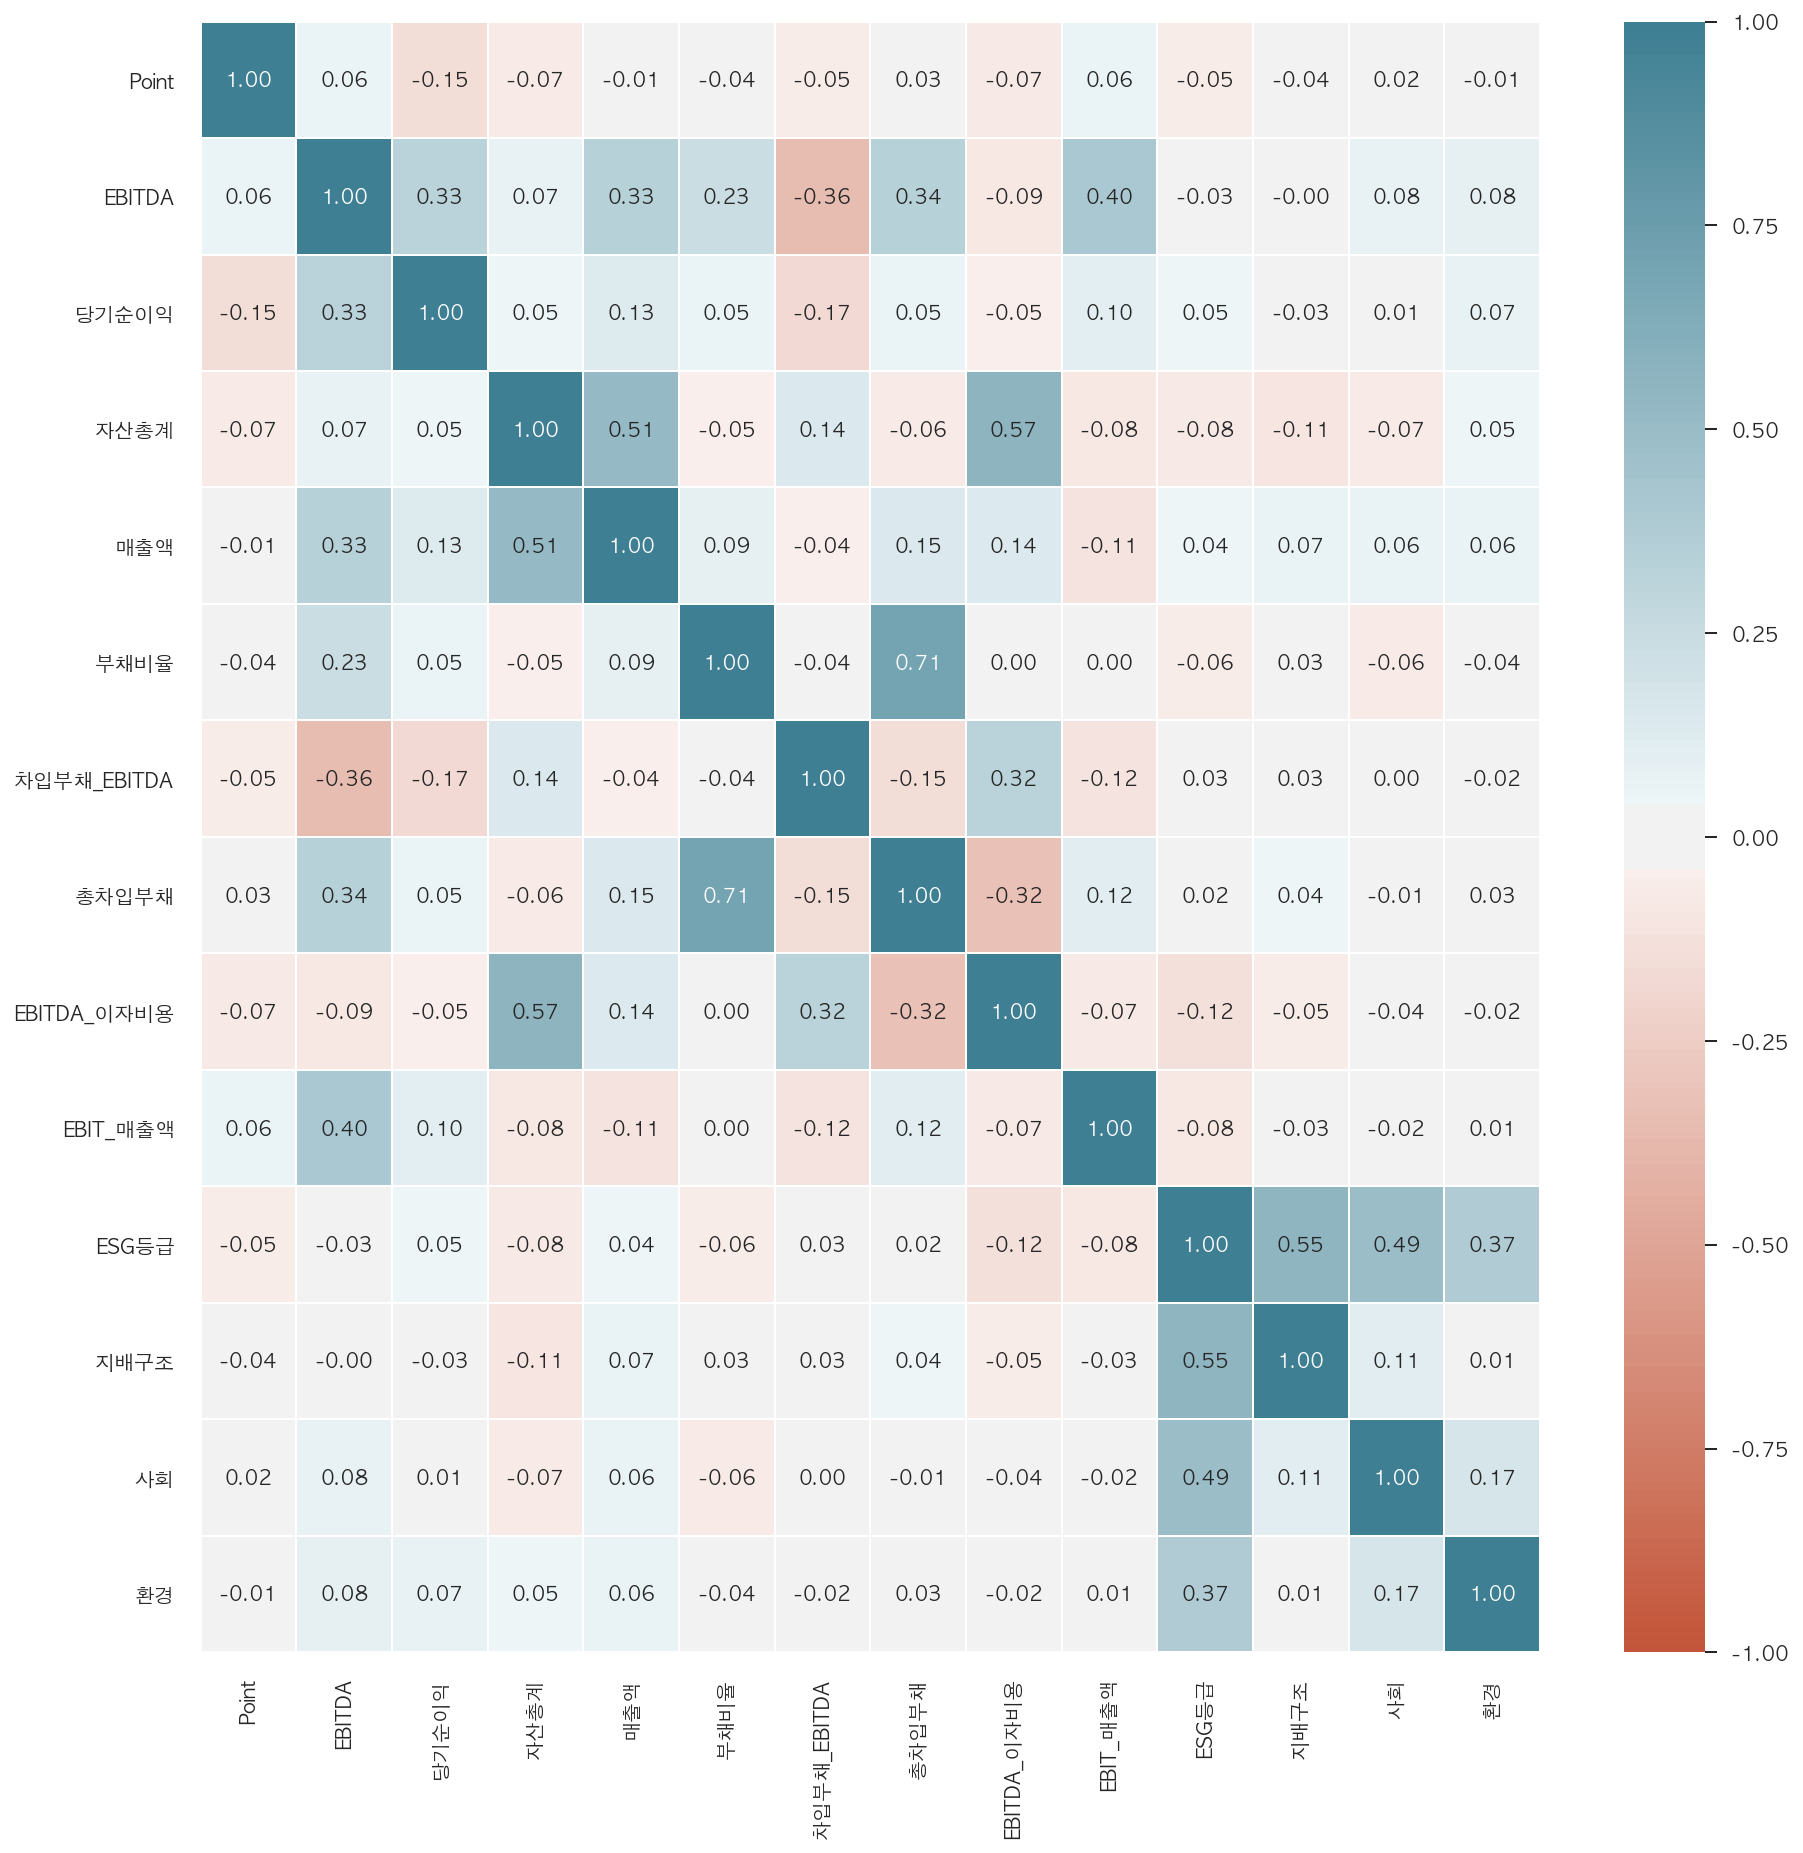

In [63]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_sum_2015_2020.corr(), annot=True,vmin=-1,
fmt = '.2f', linewidths=.5, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

In [64]:
#df_sum_2015_2020.profile_report()

In [65]:
df_x = df_sum_2015_2020.iloc[:,1:]
df_y = df_sum_2015_2020.iloc[:,0]

In [66]:
# for col in df_x.columns[:11] :
#     df_x[col] = winsorize(df_x[col], limits=0.3)

In [67]:
robust_scaler = RobustScaler()
rb = robust_scaler.fit(df_x)
output = robust_scaler.transform(df_x)
output = pd.DataFrame(output, columns=df_x.columns, index=list(df_x.index.values))
output["Point"] = df_y

In [68]:
output.describe()

,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,잉여현금흐름,EBIT_매출액,ESG등급,지배구조,사회,환경,Point
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,0.105528,-0.139615,0.214177,0.055476,0.471255,0.454881,0.556171,0.344398,-0.541329,0.692268,-0.170648,-0.030717,0.129693,-0.221843,0.153584
std,0.985531,6.782112,1.288325,1.154056,3.911118,3.528545,4.402618,2.059271,12.853559,5.305240,3.146790,0.515923,0.842110,3.184175,0.361166
min,-2.240192,-45.993928,-4.128970,-3.720895,-2.587940,-3.077529,-2.887336,-6.644551,-202.035448,-8.123941,-10.000000,-1.500000,-2.000000,-10.000000,0.000000
25%,-0.453861,-0.423251,-0.429603,-0.423764,-0.498031,-0.481188,-0.506240,-0.425539,-0.446374,-0.450830,0.000000,-0.500000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.546139,0.576749,0.570397,0.576236,0.501969,0.518812,0.493760,0.574461,0.553626,0.549170,0.000000,0.500000,1.000000,0.000000,0.000000
max,4.853689,46.333465,5.932535,4.917198,55.912766,42.776537,62.207708,20.661854,38.116148,71.697776,10.000000,1.500000,3.000000,10.000000,1.000000


In [69]:
output[output.values >5 ] = np.nan
output[output.values < -5] = np.nan
output = output.dropna()

In [70]:
output.describe()

,EBITDA,당기순이익,자산총계,매출액,부채비율,차입부채_EBITDA,총차입부채,EBITDA_이자비용,잉여현금흐름,EBIT_매출액,ESG등급,지배구조,사회,환경,Point
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.031860,0.115448,0.143166,0.023154,0.011264,0.056515,0.013080,0.195890,0.119820,0.060172,0.069767,-0.027907,0.213953,-0.069767,0.134884
std,0.807861,1.101789,1.177867,1.058646,0.961035,0.760154,0.846198,1.165346,1.242235,0.973238,2.879150,0.499217,0.870487,2.796822,0.342397
min,-2.070906,-4.957005,-4.128970,-3.121993,-2.359637,-2.435540,-2.075043,-3.696938,-3.985553,-2.490946,-5.000000,-1.500000,-2.000000,-5.000000,0.000000
25%,-0.446797,-0.339176,-0.437221,-0.398692,-0.512443,-0.372929,-0.483529,-0.426485,-0.346013,-0.427626,0.000000,-0.500000,0.000000,0.000000,0.000000
50%,-0.030060,0.000000,0.014160,-0.006215,-0.046782,0.008046,-0.040487,0.000000,0.048935,-0.046955,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.390337,0.379917,0.546428,0.545774,0.406526,0.460863,0.369121,0.563149,0.583990,0.466984,0.000000,0.500000,1.000000,0.000000,0.000000
max,3.004211,4.959554,4.640301,4.044143,3.244514,2.961719,3.991641,4.699892,4.713070,4.453907,5.000000,1.500000,3.000000,5.000000,1.000000


In [71]:
from sklearn.linear_model import LinearRegression
model = sm.OLS.from_formula("Point ~ EBITDA+당기순이익+자산총계+매출액+부채비율+차입부채_EBITDA+EBITDA_이자비용+총차입부채+잉여현금흐름+EBIT_매출액+\
                            ESG등급+지배구조+사회+환경+0",data=output)
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Point   R-squared (uncentered):                   0.048
Model:                            OLS   Adj. R-squared (uncentered):             -0.018
Method:                 Least Squares   F-statistic:                             0.7231
Date:                Sun, 28 Jun 2020   Prob (F-statistic):                       0.750
Time:                        23:18:11   Log-Likelihood:                         -84.430
No. Observations:                 215   AIC:                                      196.9
Df Residuals:                     201   BIC:                                      244.0
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [72]:
model = sm.Logit.from_formula("Point ~ EBITDA+당기순이익+자산총계+매출액+부채비율+차입부채_EBITDA+총차입부채+EBITDA_이자비용+잉여현금흐름+EBIT_매출액+\
                             ESG등급+지배구조+사회+환경+0",data=output)
result1 = model.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.618099
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Point   No. Observations:                  215
Model:                          Logit   Df Residuals:                      201
Method:                           MLE   Df Model:                           13
Date:                Sun, 28 Jun 2020   Pseudo R-squ.:                 -0.5626
Time:                        23:18:11   Log-Likelihood:                -132.89
converged:                       True   LL-Null:                       -85.047
Covariance Type:            nonrobust   LLR p-value:                     1.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
EBITDA          1.7248      0.690      2.498      0.012       0.372       3.078
당기순이익          -0.1948    

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.30, random_state=7)

In [100]:
log_clf = LogisticRegression() 
log_clf.fit(X_train,y_train) 
log_clf.score(X_test, y_test)

0.7727272727272727

In [101]:
y_pred = list(log_clf.predict(X_test))
y_true = list(np.array(y_test))

In [102]:
print(len(y_test[y_test==1].dropna()))

19


In [103]:
confusion_matrix(y_true, y_pred, labels=[1,0])

array([[ 0, 19],
       [ 1, 68]])

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87        69
         1.0       0.00      0.00      0.00        19

    accuracy                           0.77        88
   macro avg       0.39      0.49      0.44        88
weighted avg       0.61      0.77      0.68        88



In [79]:
importance = model.feature_importances_
idx = X_train.columns
pd.DataFrame(importance, index =X_train.columns, columns=["Feature_importance"]).sort_values(["Feature_importance"], ascending = False)

,Feature_importance
EBIT_매출액,0.205547
잉여현금흐름,0.162978
당기순이익,0.161348
자산총계,0.093834
EBITDA_이자비용,0.093833
매출액,0.069587
지배구조,0.058731
EBITDA,0.044573
환경,0.041295
부채비율,0.035239


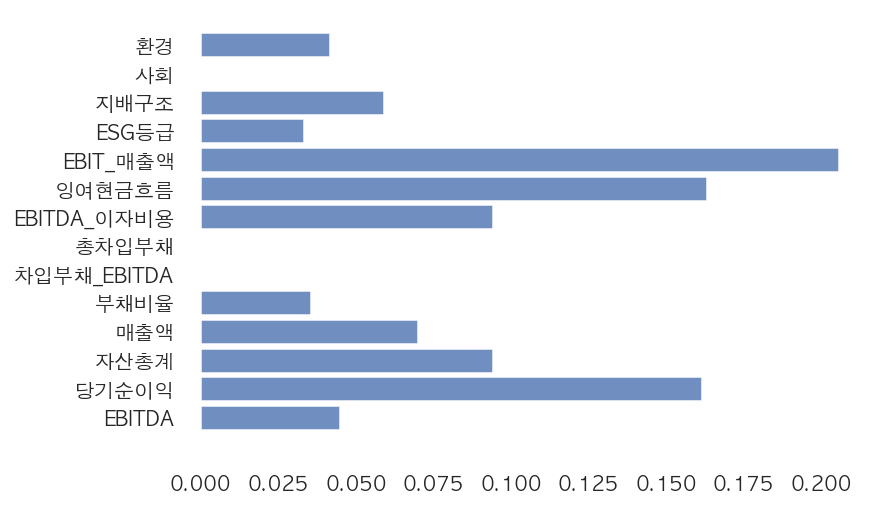

In [80]:
plt.barh(idx,importance, height = 0.8,align='center',alpha=0.8)
plt.show()